In [11]:
#importing required libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
#to plot within notebook
import matplotlib.pyplot as plt


from yahoo_fin import stock_info as si

def getpriceinfo(symbol):
    lp=si.get_live_price(symbol)

    
 
    #print(si.get_day_most_active())
 
    # get biggest gainers
    #print(si.get_day_gainers())
 
    # get worst performers
    #print(si.get_day_losers())
    return lp

def getqoutetable(symbol):
    

    qt=si.get_quote_table(symbol, dict_result = False)
 
    #print(si.get_day_most_active())
 
    # get biggest gainers
    #print(si.get_day_gainers())
 
    # get worst performers
    #print(si.get_day_losers())
    return qt

# function to calculate percentage difference considering baseValue as 100%
def percentageChange(baseValue, currentValue):
    return((float(currentValue)-baseValue) / abs(baseValue)) *100.00

# function to get the actual value using baseValue and percentage
def reversePercentageChange(baseValue, percentage):
    return float(baseValue) + float(baseValue * percentage / 100.00)

# function to transform a list of values into the list of percentages. For calculating percentages for each element in the list
# the base is always the previous element in the list.
def transformToPercentageChange(x):
    baseValue = x[0]
    x[0] = 0
    for i in range(1,len(x)):
        pChange = percentageChange(baseValue,x[i])
        baseValue = x[i]
        x[i] = pChange

# function to transform a list of percentages to the list of actual values. For calculating actual values for each element in the list
# the base is always the previous calculated element in the list.
def reverseTransformToPercentageChange(baseValue, x):
    x_transform = []
    for i in range(0,len(x)):
        value = reversePercentageChange(baseValue,x[i])
        baseValue = value
        x_transform.append(value)
    return x_transform

#read the data file
def predictpriceofdata(stockname):
    df = pd.read_csv('data\\'+stockname+'.csv')
# store the first element in the series as the base value for future use.
    baseValue = df['Close'][0]

# create a new dataframe which is then transformed into relative percentages
    data = df.sort_index(ascending=True, axis=0)
    new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
    for i in range(0,len(data)):
        new_data['Date'][i] = data['Date'][i]
        new_data['Close'][i] = data['Close'][i]

# transform the 'Close' series into relative percentages
    transformToPercentageChange(new_data['Close'])

# set Dat column as the index
    new_data.index = new_data.Date
    new_data.drop('Date', axis=1, inplace=True)

# create train and test sets
    dataset = new_data.values
    train, valid = train_test_split(dataset, train_size=0.99, test_size=0.01, shuffle=False)

# convert dataset into x_train and y_train.
# prediction_window_size is the size of days windows which will be considered for predicting a future value.
    prediction_window_size = 60
    x_train, y_train = [], []
    for i in range(prediction_window_size,len(train)):
        x_train.append(dataset[i-prediction_window_size:i,0])
        y_train.append(dataset[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

##################################################################################################
# create and fit the LSTM network
# Initialising the RNN
    model = Sequential()
# Adding the first LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
    model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))

# Adding the output layer
    model.add(Dense(units = 1))
# Compiling the RNN
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
    model.fit(x_train, y_train, epochs = 1, batch_size = 1000)

##################################################################################################

#predicting future values, using past 60 from the train data
# for next 10 yrs total_prediction_days is set to 3650 days
    total_prediction_days = 3650
    inputs = new_data[-total_prediction_days:].values
    inputs = inputs.reshape(-1,1)

# create future predict list which is a two dimensional list of values.
# the first dimension is the total number of future days
# the second dimension is the list of values of prediction_window_size size
    X_predict = []
    for i in range(prediction_window_size,inputs.shape[0]):
        X_predict.append(inputs[i-prediction_window_size:i,0])
    X_predict = np.array(X_predict)

# predict the future
    X_predict = np.reshape(X_predict, (X_predict.shape[0],X_predict.shape[1],1))
    future_closing_price = model.predict(X_predict)

    train, valid = train_test_split(new_data, train_size=0.99, test_size=0.01, shuffle=False)
    date_index = pd.to_datetime(train.index)

#converting dates into number of days as dates cannot be passed directly to any regression model
    x_days = (date_index - pd.to_datetime('1970-01-01')).days

# we are doing prediction for next 5 years hence prediction_for_days is set to 1500 days.
    prediction_for_days = 300
    future_closing_price = future_closing_price[:prediction_for_days]

# create a data index for future dates
    x_predict_future_dates = np.asarray(pd.RangeIndex(start=x_days[-1] + 1, stop=x_days[-1] + 1 + (len(future_closing_price))))
    future_date_index = pd.to_datetime(x_predict_future_dates, origin='1970-01-01', unit='D')

# transform a list of relative percentages to the actual values
    train_transform = reverseTransformToPercentageChange(baseValue, train['Close'])

# for future dates the base value the the value of last element from the training set.
    baseValue = train_transform[-1]
    valid_transform = reverseTransformToPercentageChange(baseValue, valid['Close'])
    future_closing_price_transform = reverseTransformToPercentageChange(baseValue, future_closing_price)

# recession peak date is the date on which the index is at the bottom most position.
    recessionPeakDate =  future_date_index[future_closing_price_transform.index(min(future_closing_price_transform))]
    minCloseInFuture = min(future_closing_price_transform);
    print("The stock market will reach to its lowest bottom on", recessionPeakDate)
    print("The lowest index the stock market will fall to is ", minCloseInFuture)

# plot the graphs
    plt.figure(figsize=(16,8))
    df_x = pd.to_datetime(new_data.index)
    plt.plot(date_index,train_transform, label='Close Price History')
    plt.plot(future_date_index,future_closing_price_transform, label='Predicted Close')

# set the title of the graph
    plt.suptitle('Stock Market Predictions', fontsize=16)

# set the title of the graph window
    fig = plt.gcf()
    fig.canvas.set_window_title('Stock Market Predictions')

#display the legends
    plt.legend()

#display the graph
    plt.show()
    
    dictofdateandprice={}
    
    for i in range(38,50):
        dictofdateandprice[str(future_date_index[i])]=future_closing_price_transform[i]
    return dictofdateandprice

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://0.0.0.0:5000/ (Press CTRL+C to quit)


company for qoute GOOGL


127.0.0.1 - - [14/Sep/2020 19:20:53] "GET /fetchprice?msg=GOOGL HTTP/1.1" 200 -


price is
1536.760009765625


127.0.0.1 - - [14/Sep/2020 19:20:54] "GET /getqoutetableval?msg=GOOGL HTTP/1.1" 200 -


qoute is
                   attribute                        value
0              1y Target Est                      1763.81
1              52 Week Range          1,008.87 - 1,726.10
2                        Ask               1,527.58 x 800
3                Avg. Volume                  1.80282e+06
4          Beta (5Y Monthly)                         1.08
5                        Bid               1,525.34 x 800
6                Day's Range          1,524.10 - 1,537.78
7                  EPS (TTM)                        45.49
8              Earnings Date  Oct 26, 2020 - Oct 30, 2020
9           Ex-Dividend Date                          NaN
10  Forward Dividend & Yield                    N/A (N/A)
11                Market Cap                       1.046T
12                      Open                      1531.65
13            PE Ratio (TTM)                        33.76
14            Previous Close                      1515.76
15               Quote Price                      1536.76
16   

127.0.0.1 - - [14/Sep/2020 19:21:05] "GET /fetchprice?msg=GOOGL HTTP/1.1" 200 -


price is
1536.760009765625


127.0.0.1 - - [14/Sep/2020 19:21:07] "GET /getqoutetableval?msg=GOOGL HTTP/1.1" 200 -


qoute is
                   attribute                        value
0              1y Target Est                      1763.81
1              52 Week Range          1,008.87 - 1,726.10
2                        Ask               1,527.58 x 800
3                Avg. Volume                  1.80282e+06
4          Beta (5Y Monthly)                         1.08
5                        Bid               1,523.00 x 800
6                Day's Range          1,524.10 - 1,537.78
7                  EPS (TTM)                        45.49
8              Earnings Date  Oct 26, 2020 - Oct 30, 2020
9           Ex-Dividend Date                          NaN
10  Forward Dividend & Yield                    N/A (N/A)
11                Market Cap                       1.046T
12                      Open                      1531.65
13            PE Ratio (TTM)                        33.76
14            Previous Close                      1515.76
15               Quote Price                      1536.76
16   

127.0.0.1 - - [14/Sep/2020 19:21:08] "GET /null HTTP/1.1" 404 -
127.0.0.1 - - [14/Sep/2020 19:21:08] "GET /null HTTP/1.1" 404 -


AMZN


127.0.0.1 - - [14/Sep/2020 19:21:10] "GET /searchforcompany?company=Amazon.com+Inc. HTTP/1.1" 200 -


Looking for a job? Amazon hiring 33,000 workers for corporate and tech roles with average pay of $150,000Joseph Pisani 
How to make phone calls with Alexa and Google speakersJefferson Graham 
Amazon bans foreign seeds, plants sales as investigation over mysterious packages continuesKelly Tyko 
Amazon survey finds more than half of US workers say coronavirus has left them underemployedCharisse Jones 
10 popular face masks everyone is buying on AmazonCourtney Campbell 
The 5 best Amazon deals you can get this ThursdayMelissa Lee 
Amazon is set to hire new workers as it leases more real estate in Washington stateDalvin Brown 
The 5 best Amazon deals you can get this weekendMelissa Lee 
The 5 best Amazon deals you can get this FridayMelissa Lee 
Amazon is giving you $10 if you can spend 8 hours a month to watching TVRick Munarriz 
The 5 best Amazon deals you can get this weekendNicole Briese 
Jeff Bezos' ex, MacKenzie Scott, is now the wealthiest woman in the worldCoral Murphy 
Walmart's n

127.0.0.1 - - [14/Sep/2020 19:21:15] "GET /parsenews?msg=https%3A%2F%2Fwww.usatoday.com%2Fstory%2Ftech%2F2020%2F09%2F10%2Fhow-make-free-phone-calls-google-and-alexa-speakers%2F5759920002%2F HTTP/1.1" 200 -


<a href='https://www.usatoday.com/story/tech/2020/09/10/how-make-free-phone-calls-google-and-alexa-speakers/5759920002/' target="_blank" >https://www.usatoday.com/story/tech/2020/09/10/how-make-free-phone-calls-google-and-alexa-speakers/5759920002/</a><br>
<a href='https://www.usatoday.com/story/tech/2020/09/10/how-make-free-phone-calls-google-and-alexa-speakers/5759920002/' target="_blank" >https://www.usatoday.com/story/tech/2020/09/10/how-make-free-phone-calls-google-and-alexa-speakers/5759920002/</a><br>Beyond asking for the latest temperature, calendar appointments and recipes, Amazon Echo and Google Nest Hub devices can be used for phone calls. But it's complicated. Amazon announced on Wednesday a new alliance with wireless carrier AT&T to enable AT&T customers (on "eligible rate plans") to link their mobile numbers and turn their speaker into a two-way phone. This will enable them to make calls and answer their phone from contacts at home by saying "Alexa answer" without having 

127.0.0.1 - - [14/Sep/2020 19:21:18] "GET /parsenews?msg=https%3A%2F%2Fwww.usatoday.com%2Fstory%2Fmoney%2F2020%2F09%2F09%2Fjob-search-covid-19-pandemic-workers-underemployed-unemployment%2F5751028002%2F HTTP/1.1" 200 -



<a href='https://www.usatoday.com/story/money/2020/09/09/job-search-covid-19-pandemic-workers-underemployed-unemployment/5751028002/' target="_blank" >https://www.usatoday.com/story/money/2020/09/09/job-search-covid-19-pandemic-workers-underemployed-unemployment/5751028002/</a><br>More than half of the U.S. workers seeking work say their job hunt is due to the coronavirus pandemic. That's a key finding of a new survey by e-commerce giant Amazon, which found that a quarter of U.S. workers are looking for new employment, while 27% say that at least some of their skills won't be of use in the job market in the next five years. The survey, conducted by Morning Consult between Aug. 21 and 28, comes at a time when the nation's unemployment rate hovers at 8.4% as the economy haltingly returns from a shutdown sparked in the spring to slow the spread of the coronavirus.  Among workers, 36% say they are not working as many hours as they want to or are taking on tasks that don’t tap their primar

127.0.0.1 - - [14/Sep/2020 19:21:20] "GET /parsenews?msg=https%3A%2F%2Fwww.usatoday.com%2Fstory%2Fmoney%2F2020%2F09%2F06%2Fmysterious-seeds-from-china-amazon-updates-seed-plant-policy%2F5734283002%2F HTTP/1.1" 200 -


<a href='https://www.usatoday.com/story/money/2020/09/06/mysterious-seeds-from-china-amazon-updates-seed-plant-policy/5734283002/' target="_blank" >https://www.usatoday.com/story/money/2020/09/06/mysterious-seeds-from-china-amazon-updates-seed-plant-policy/5734283002/</a><br>
<a href='https://www.usatoday.com/story/money/2020/09/06/mysterious-seeds-from-china-amazon-updates-seed-plant-policy/5734283002/' target="_blank" >https://www.usatoday.com/story/money/2020/09/06/mysterious-seeds-from-china-amazon-updates-seed-plant-policy/5734283002/</a><br>After thousands of Americans received mysterious packages of seeds unsolicited from China this summer, Amazon has changed its policy to ban sales of plants and seeds imported from outside the U.S. The plants and seeds' seller policy was updated Sept. 2, according to the company's website, and was first reported by the Wall Street Journal. As part of the change, sales of seeds, plant products and plants by non-U.S. residents are prohibited. The

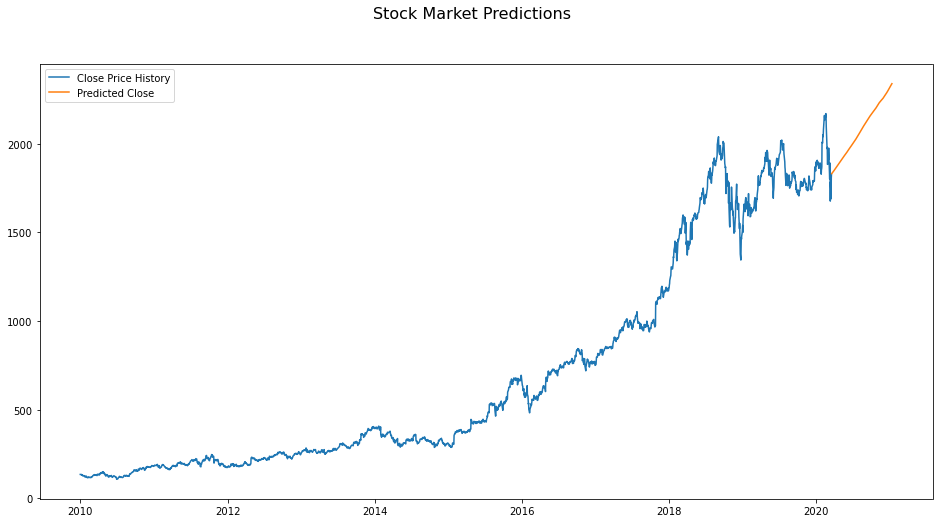

127.0.0.1 - - [14/Sep/2020 19:21:20] "GET /futurepriceprediction?msg=AMZN HTTP/1.1" 200 -


{'2020-04-26 00:00:00': 1893.1771314144135, '2020-04-27 00:00:00': 1894.756563425064, '2020-04-28 00:00:00': 1896.3169325590134, '2020-04-29 00:00:00': 1897.8658820390701, '2020-04-30 00:00:00': 1899.4172027111053, '2020-05-01 00:00:00': 1900.976204276085, '2020-05-02 00:00:00': 1902.5380383729935, '2020-05-03 00:00:00': 1904.1041275262833, '2020-05-04 00:00:00': 1905.681489109993, '2020-05-05 00:00:00': 1907.2690904140472, '2020-05-06 00:00:00': 1908.8600494861603, '2020-05-07 00:00:00': 1910.443410038948}


127.0.0.1 - - [14/Sep/2020 19:21:22] "GET /parsenews?msg=https%3A%2F%2Fwww.usatoday.com%2Fstory%2Ftech%2Freviewedcom%2F2020%2F07%2F21%2F10-most-popular-face-masks-you-can-buy-amazon%2F5482759002%2F HTTP/1.1" 200 -


<a href='https://www.usatoday.com/story/tech/reviewedcom/2020/07/21/10-most-popular-face-masks-you-can-buy-amazon/5482759002/' target="_blank" >https://www.usatoday.com/story/tech/reviewedcom/2020/07/21/10-most-popular-face-masks-you-can-buy-amazon/5482759002/</a><br>
<a href='https://www.usatoday.com/story/tech/reviewedcom/2020/07/21/10-most-popular-face-masks-you-can-buy-amazon/5482759002/' target="_blank" >https://www.usatoday.com/story/tech/reviewedcom/2020/07/21/10-most-popular-face-masks-you-can-buy-amazon/5482759002/</a><br>
company for qoute AMZN


127.0.0.1 - - [14/Sep/2020 19:21:23] "GET /fetchprice?msg=AMZN HTTP/1.1" 200 -


price is
3169.840087890625


127.0.0.1 - - [14/Sep/2020 19:21:23] "GET /parsenews?msg=https%3A%2F%2Fwww.usatoday.com%2Fstory%2Ftech%2Freviewedcom%2F2020%2F09%2F10%2Famazon-sale-shop-markdowns-oven-mitts-no-touch-thermometers-and-more%2F3460465001%2F HTTP/1.1" 200 -


<a href='https://www.usatoday.com/story/tech/reviewedcom/2020/09/10/amazon-sale-shop-markdowns-oven-mitts-no-touch-thermometers-and-more/3460465001/' target="_blank" >https://www.usatoday.com/story/tech/reviewedcom/2020/09/10/amazon-sale-shop-markdowns-oven-mitts-no-touch-thermometers-and-more/3460465001/</a><br>
<a href='https://www.usatoday.com/story/tech/reviewedcom/2020/09/10/amazon-sale-shop-markdowns-oven-mitts-no-touch-thermometers-and-more/3460465001/' target="_blank" >https://www.usatoday.com/story/tech/reviewedcom/2020/09/10/amazon-sale-shop-markdowns-oven-mitts-no-touch-thermometers-and-more/3460465001/</a><br>


127.0.0.1 - - [14/Sep/2020 19:21:25] "GET /getqoutetableval?msg=AMZN HTTP/1.1" 200 -


qoute is
                   attribute                        value
0              1y Target Est                      3661.68
1              52 Week Range          1,626.03 - 3,552.25
2                        Ask              3,146.43 x 1400
3                Avg. Volume                  4.84433e+06
4          Beta (5Y Monthly)                         1.32
5                        Bid              3,146.34 x 1000
6                Day's Range          3,144.25 - 3,178.77
7                  EPS (TTM)                        26.04
8              Earnings Date  Oct 29, 2020 - Nov 05, 2020
9           Ex-Dividend Date                          NaN
10  Forward Dividend & Yield                    N/A (N/A)
11                Market Cap                       1.586T
12                      Open                      3172.94
13            PE Ratio (TTM)                       121.64
14            Previous Close                      3116.22
15               Quote Price                      3169.84
16   

127.0.0.1 - - [14/Sep/2020 19:21:26] "GET /parsenews?msg=https%3A%2F%2Fwww.usatoday.com%2Fstory%2Ftech%2Freviewedcom%2F2020%2F09%2F12%2Famazon-sale-save-lodge-dutch-oven-bluetooth-speaker-and-more%2F5778751002%2F HTTP/1.1" 200 -


<a href='https://www.usatoday.com/story/tech/reviewedcom/2020/09/12/amazon-sale-save-lodge-dutch-oven-bluetooth-speaker-and-more/5778751002/' target="_blank" >https://www.usatoday.com/story/tech/reviewedcom/2020/09/12/amazon-sale-save-lodge-dutch-oven-bluetooth-speaker-and-more/5778751002/</a><br>
<a href='https://www.usatoday.com/story/tech/reviewedcom/2020/09/12/amazon-sale-save-lodge-dutch-oven-bluetooth-speaker-and-more/5778751002/' target="_blank" >https://www.usatoday.com/story/tech/reviewedcom/2020/09/12/amazon-sale-save-lodge-dutch-oven-bluetooth-speaker-and-more/5778751002/</a><br>


127.0.0.1 - - [14/Sep/2020 19:21:28] "GET /parsenews?msg=https%3A%2F%2Fwww.usatoday.com%2Fstory%2Ftech%2Freviewedcom%2F2020%2F09%2F08%2Finstant-pot-deals-get-best-selling-instant-pot-duo-nova-sale%2F5744943002%2F HTTP/1.1" 200 -


<a href='https://www.usatoday.com/story/tech/reviewedcom/2020/09/08/instant-pot-deals-get-best-selling-instant-pot-duo-nova-sale/5744943002/' target="_blank" >https://www.usatoday.com/story/tech/reviewedcom/2020/09/08/instant-pot-deals-get-best-selling-instant-pot-duo-nova-sale/5744943002/</a><br>
<a href='https://www.usatoday.com/story/tech/reviewedcom/2020/09/08/instant-pot-deals-get-best-selling-instant-pot-duo-nova-sale/5744943002/' target="_blank" >https://www.usatoday.com/story/tech/reviewedcom/2020/09/08/instant-pot-deals-get-best-selling-instant-pot-duo-nova-sale/5744943002/</a><br>


127.0.0.1 - - [14/Sep/2020 19:21:30] "GET /parsenews?msg=https%3A%2F%2Fwww.usatoday.com%2Fstory%2Ftech%2F2020%2F09%2F04%2Famazon-rebuffed-again-pentagon-reaffirms-microsoft-jedi-deal%2F5722132002%2F HTTP/1.1" 200 -


<a href='https://www.usatoday.com/story/tech/2020/09/04/amazon-rebuffed-again-pentagon-reaffirms-microsoft-jedi-deal/5722132002/' target="_blank" >https://www.usatoday.com/story/tech/2020/09/04/amazon-rebuffed-again-pentagon-reaffirms-microsoft-jedi-deal/5722132002/</a><br>
<a href='https://www.usatoday.com/story/tech/2020/09/04/amazon-rebuffed-again-pentagon-reaffirms-microsoft-jedi-deal/5722132002/' target="_blank" >https://www.usatoday.com/story/tech/2020/09/04/amazon-rebuffed-again-pentagon-reaffirms-microsoft-jedi-deal/5722132002/</a><br>WASHINGTON – The Pentagon on Friday reaffirmed Microsoft as winner of a cloud computing contract potentially worth $10 billion, although the start of work is delayed by a legal battle over rival Amazon’s claim that the bidding process was flawed. “The department has completed its comprehensive re-evaluation of the JEDI cloud proposals and determined that Microsoft’s proposal continues to represent the best value to the government,” the Pentagon sa

127.0.0.1 - - [14/Sep/2020 19:21:33] "GET /parsenews?msg=https%3A%2F%2Fwww.usatoday.com%2Fstory%2Fmoney%2F2020%2F09%2F01%2Ffree-shipping-walmart-plus-amazon-prime-shipt-instacart-doordash%2F3454381001%2F HTTP/1.1" 200 -


<a href='https://www.usatoday.com/story/money/2020/09/01/free-shipping-walmart-plus-amazon-prime-shipt-instacart-doordash/3454381001/' target="_blank" >https://www.usatoday.com/story/money/2020/09/01/free-shipping-walmart-plus-amazon-prime-shipt-instacart-doordash/3454381001/</a><br>
<a href='https://www.usatoday.com/story/money/2020/09/01/free-shipping-walmart-plus-amazon-prime-shipt-instacart-doordash/3454381001/' target="_blank" >https://www.usatoday.com/story/money/2020/09/01/free-shipping-walmart-plus-amazon-prime-shipt-instacart-doordash/3454381001/</a><br>With many shoppers looking to make fewer trips into stores amid the coronavirus pandemic, on-demand grocery shopping has been growing in popularity. Walmart, which has seen tremendous growth in digital sales, is now planning to expand on a pilot of its Delivery Unlimited program with the new Walmart+ membership program that launches Sept. 15 and offers delivery as fast as same-day, an easier store checkout and a fuel discount. 

127.0.0.1 - - [14/Sep/2020 19:21:35] "GET /fetchprice?msg=AMZN HTTP/1.1" 200 -


price is
3169.840087890625


127.0.0.1 - - [14/Sep/2020 19:21:38] "GET /getqoutetableval?msg=AMZN HTTP/1.1" 200 -


qoute is
                   attribute                        value
0              1y Target Est                      3661.68
1              52 Week Range          1,626.03 - 3,552.25
2                        Ask              3,146.43 x 1400
3                Avg. Volume                  4.84433e+06
4          Beta (5Y Monthly)                         1.32
5                        Bid              3,146.34 x 1000
6                Day's Range          3,144.25 - 3,178.77
7                  EPS (TTM)                        26.04
8              Earnings Date  Oct 29, 2020 - Nov 05, 2020
9           Ex-Dividend Date                          NaN
10  Forward Dividend & Yield                    N/A (N/A)
11                Market Cap                       1.586T
12                      Open                      3172.94
13            PE Ratio (TTM)                       121.62
14            Previous Close                      3116.22
15               Quote Price                      3166.69
16   

127.0.0.1 - - [14/Sep/2020 19:21:47] "GET /fetchprice?msg=AMZN HTTP/1.1" 200 -


price is
3167.22998046875


127.0.0.1 - - [14/Sep/2020 19:21:49] "GET /getqoutetableval?msg=AMZN HTTP/1.1" 200 -


qoute is
                   attribute                        value
0              1y Target Est                      3661.68
1              52 Week Range          1,626.03 - 3,552.25
2                        Ask              3,151.58 x 1400
3                Avg. Volume                  4.84433e+06
4          Beta (5Y Monthly)                         1.32
5                        Bid              3,146.34 x 1000
6                Day's Range          3,144.25 - 3,178.77
7                  EPS (TTM)                        26.04
8              Earnings Date  Oct 29, 2020 - Nov 05, 2020
9           Ex-Dividend Date                          NaN
10  Forward Dividend & Yield                    N/A (N/A)
11                Market Cap                       1.586T
12                      Open                      3172.94
13            PE Ratio (TTM)                       121.64
14            Previous Close                      3116.22
15               Quote Price                      3169.84
16   

127.0.0.1 - - [14/Sep/2020 19:21:59] "GET /fetchprice?msg=AMZN HTTP/1.1" 200 -


price is
3167.22998046875


127.0.0.1 - - [14/Sep/2020 19:22:01] "GET /getqoutetableval?msg=AMZN HTTP/1.1" 200 -


qoute is
                   attribute                        value
0              1y Target Est                      3661.68
1              52 Week Range          1,626.03 - 3,552.25
2                        Ask              3,151.58 x 1400
3                Avg. Volume                  4.84433e+06
4          Beta (5Y Monthly)                         1.32
5                        Bid              3,150.78 x 1000
6                Day's Range          3,144.25 - 3,178.77
7                  EPS (TTM)                        26.04
8              Earnings Date  Oct 29, 2020 - Nov 05, 2020
9           Ex-Dividend Date                          NaN
10  Forward Dividend & Yield                    N/A (N/A)
11                Market Cap                       1.586T
12                      Open                      3172.94
13            PE Ratio (TTM)                       121.64
14            Previous Close                      3116.22
15               Quote Price                      3167.23
16   

127.0.0.1 - - [14/Sep/2020 19:22:11] "GET /fetchprice?msg=AMZN HTTP/1.1" 200 -



3167.06005859375


127.0.0.1 - - [14/Sep/2020 19:22:12] "GET /getqoutetableval?msg=AMZN HTTP/1.1" 200 -


qoute is
                   attribute                        value
0              1y Target Est                      3661.68
1              52 Week Range          1,626.03 - 3,552.25
2                        Ask              3,151.58 x 1400
3                Avg. Volume                  4.84433e+06
4          Beta (5Y Monthly)                         1.32
5                        Bid              3,150.78 x 1000
6                Day's Range          3,144.25 - 3,178.77
7                  EPS (TTM)                        26.04
8              Earnings Date  Oct 29, 2020 - Nov 05, 2020
9           Ex-Dividend Date                          NaN
10  Forward Dividend & Yield                    N/A (N/A)
11                Market Cap                       1.586T
12                      Open                      3172.94
13            PE Ratio (TTM)                       121.64
14            Previous Close                      3116.22
15               Quote Price                      3167.06
16   

127.0.0.1 - - [14/Sep/2020 19:22:23] "GET /fetchprice?msg=AMZN HTTP/1.1" 200 -


price is
3169.840087890625


127.0.0.1 - - [14/Sep/2020 19:22:25] "GET /getqoutetableval?msg=AMZN HTTP/1.1" 200 -


qoute is
                   attribute                        value
0              1y Target Est                      3661.68
1              52 Week Range          1,626.03 - 3,552.25
2                        Ask              3,151.58 x 1400
3                Avg. Volume                  4.84433e+06
4          Beta (5Y Monthly)                         1.32
5                        Bid              3,150.78 x 1000
6                Day's Range          3,144.25 - 3,178.77
7                  EPS (TTM)                        26.04
8              Earnings Date  Oct 29, 2020 - Nov 05, 2020
9           Ex-Dividend Date                          NaN
10  Forward Dividend & Yield                    N/A (N/A)
11                Market Cap                       1.586T
12                      Open                      3172.94
13            PE Ratio (TTM)                       121.58
14            Previous Close                      3116.22
15               Quote Price                      3169.84
16   

127.0.0.1 - - [14/Sep/2020 19:22:35] "GET /fetchprice?msg=AMZN HTTP/1.1" 200 -


price is
3164.550048828125


127.0.0.1 - - [14/Sep/2020 19:22:37] "GET /getqoutetableval?msg=AMZN HTTP/1.1" 200 -


qoute is
                   attribute                        value
0              1y Target Est                      3661.68
1              52 Week Range          1,626.03 - 3,552.25
2                        Ask              3,158.10 x 1400
3                Avg. Volume                  4.84433e+06
4          Beta (5Y Monthly)                         1.32
5                        Bid              3,155.71 x 1000
6                Day's Range          3,144.25 - 3,178.77
7                  EPS (TTM)                        26.04
8              Earnings Date  Oct 29, 2020 - Nov 05, 2020
9           Ex-Dividend Date                          NaN
10  Forward Dividend & Yield                    N/A (N/A)
11                Market Cap                       1.585T
12                      Open                      3172.94
13            PE Ratio (TTM)                       121.54
14            Previous Close                      3116.22
15               Quote Price                      3164.55
16   

127.0.0.1 - - [14/Sep/2020 19:22:47] "GET /fetchprice?msg=AMZN HTTP/1.1" 200 -


price is
3169.840087890625


127.0.0.1 - - [14/Sep/2020 19:22:48] "GET /getqoutetableval?msg=AMZN HTTP/1.1" 200 -


qoute is
                   attribute                        value
0              1y Target Est                      3661.68
1              52 Week Range          1,626.03 - 3,552.25
2                        Ask              3,158.10 x 1400
3                Avg. Volume                  4.84433e+06
4          Beta (5Y Monthly)                         1.32
5                        Bid              3,155.71 x 1000
6                Day's Range          3,144.25 - 3,178.77
7                  EPS (TTM)                        26.04
8              Earnings Date  Oct 29, 2020 - Nov 05, 2020
9           Ex-Dividend Date                          NaN
10  Forward Dividend & Yield                    N/A (N/A)
11                Market Cap                       1.585T
12                      Open                      3172.94
13            PE Ratio (TTM)                       121.53
14            Previous Close                      3116.22
15               Quote Price                      3164.36
16   

127.0.0.1 - - [14/Sep/2020 19:22:59] "GET /fetchprice?msg=AMZN HTTP/1.1" 200 -


price is
3162.97998046875


127.0.0.1 - - [14/Sep/2020 19:23:00] "GET /getqoutetableval?msg=AMZN HTTP/1.1" 200 -


qoute is
                   attribute                        value
0              1y Target Est                      3661.68
1              52 Week Range          1,626.03 - 3,552.25
2                        Ask              3,158.10 x 1400
3                Avg. Volume                  4.84433e+06
4          Beta (5Y Monthly)                         1.32
5                        Bid              3,155.71 x 1000
6                Day's Range          3,144.25 - 3,178.77
7                  EPS (TTM)                        26.04
8              Earnings Date  Oct 29, 2020 - Nov 05, 2020
9           Ex-Dividend Date                          NaN
10  Forward Dividend & Yield                    N/A (N/A)
11                Market Cap                       1.584T
12                      Open                      3172.94
13            PE Ratio (TTM)                       121.48
14            Previous Close                      3116.22
15               Quote Price                      3161.65
16   

127.0.0.1 - - [14/Sep/2020 19:23:11] "GET /fetchprice?msg=AMZN HTTP/1.1" 200 -


price is
3159.23388671875


127.0.0.1 - - [14/Sep/2020 19:23:13] "GET /getqoutetableval?msg=AMZN HTTP/1.1" 200 -


qoute is
                   attribute                        value
0              1y Target Est                      3661.68
1              52 Week Range          1,626.03 - 3,552.25
2                        Ask              3,158.10 x 1400
3                Avg. Volume                  4.84433e+06
4          Beta (5Y Monthly)                         1.32
5                        Bid              3,155.71 x 1000
6                Day's Range          3,144.25 - 3,178.77
7                  EPS (TTM)                        26.04
8              Earnings Date  Oct 29, 2020 - Nov 05, 2020
9           Ex-Dividend Date                          NaN
10  Forward Dividend & Yield                    N/A (N/A)
11                Market Cap                       1.582T
12                      Open                      3172.94
13            PE Ratio (TTM)                       121.34
14            Previous Close                      3116.22
15               Quote Price                      3159.92
16   

127.0.0.1 - - [14/Sep/2020 19:23:23] "GET /fetchprice?msg=AMZN HTTP/1.1" 200 -


company for qoute AMZN
price is
3157.02490234375


127.0.0.1 - - [14/Sep/2020 19:23:24] "GET /getqoutetableval?msg=AMZN HTTP/1.1" 200 -


qoute is
                   attribute                        value
0              1y Target Est                      3661.68
1              52 Week Range          1,626.03 - 3,552.25
2                        Ask              3,158.00 x 1400
3                Avg. Volume                  4.84433e+06
4          Beta (5Y Monthly)                         1.32
5                        Bid              3,154.99 x 1000
6                Day's Range          3,144.25 - 3,178.77
7                  EPS (TTM)                        26.04
8              Earnings Date  Oct 29, 2020 - Nov 05, 2020
9           Ex-Dividend Date                          NaN
10  Forward Dividend & Yield                    N/A (N/A)
11                Market Cap                       1.581T
12                      Open                      3172.94
13            PE Ratio (TTM)                       121.25
14            Previous Close                      3116.22
15               Quote Price                      3161.65
16   

127.0.0.1 - - [14/Sep/2020 19:23:35] "GET /fetchprice?msg=AMZN HTTP/1.1" 200 -


price is
3160.405029296875


127.0.0.1 - - [14/Sep/2020 19:23:36] "GET /getqoutetableval?msg=AMZN HTTP/1.1" 200 -


qoute is
                   attribute                        value
0              1y Target Est                      3661.68
1              52 Week Range          1,626.03 - 3,552.25
2                        Ask              3,158.00 x 1400
3                Avg. Volume                  4.84433e+06
4          Beta (5Y Monthly)                         1.32
5                        Bid              3,154.99 x 1000
6                Day's Range          3,144.25 - 3,178.77
7                  EPS (TTM)                        26.04
8              Earnings Date  Oct 29, 2020 - Nov 05, 2020
9           Ex-Dividend Date                          NaN
10  Forward Dividend & Yield                    N/A (N/A)
11                Market Cap                       1.583T
12                      Open                      3172.94
13            PE Ratio (TTM)                       121.38
14            Previous Close                      3116.22
15               Quote Price                      3161.02
16   

127.0.0.1 - - [14/Sep/2020 19:23:47] "GET /fetchprice?msg=AMZN HTTP/1.1" 200 -


price is
3161.64501953125


127.0.0.1 - - [14/Sep/2020 19:23:49] "GET /getqoutetableval?msg=AMZN HTTP/1.1" 200 -


qoute is
                   attribute                        value
0              1y Target Est                      3661.68
1              52 Week Range          1,626.03 - 3,552.25
2                        Ask              3,158.00 x 1400
3                Avg. Volume                  4.84433e+06
4          Beta (5Y Monthly)                         1.32
5                        Bid              3,154.99 x 1000
6                Day's Range          3,144.25 - 3,178.77
7                  EPS (TTM)                        26.04
8              Earnings Date  Oct 29, 2020 - Nov 05, 2020
9           Ex-Dividend Date                          NaN
10  Forward Dividend & Yield                    N/A (N/A)
11                Market Cap                       1.583T
12                      Open                      3172.94
13            PE Ratio (TTM)                       121.35
14            Previous Close                      3116.22
15               Quote Price                      3159.67
16   

127.0.0.1 - - [14/Sep/2020 19:23:59] "GET /fetchprice?msg=AMZN HTTP/1.1" 200 -


price is
3158.419921875


127.0.0.1 - - [14/Sep/2020 19:24:00] "GET /getqoutetableval?msg=AMZN HTTP/1.1" 200 -


qoute is
                   attribute                        value
0              1y Target Est                      3661.68
1              52 Week Range          1,626.03 - 3,552.25
2                        Ask              3,158.00 x 1400
3                Avg. Volume                  4.84433e+06
4          Beta (5Y Monthly)                         1.32
5                        Bid              3,154.99 x 1000
6                Day's Range          3,144.25 - 3,178.77
7                  EPS (TTM)                        26.04
8              Earnings Date  Oct 29, 2020 - Nov 05, 2020
9           Ex-Dividend Date                          NaN
10  Forward Dividend & Yield                    N/A (N/A)
11                Market Cap                       1.582T
12                      Open                      3172.94
13            PE Ratio (TTM)                       121.31
14            Previous Close                      3116.22
15               Quote Price                      3161.65
16   

127.0.0.1 - - [14/Sep/2020 19:24:11] "GET /fetchprice?msg=AMZN HTTP/1.1" 200 -


company for qoute AMZN
price is
3160.074951171875


127.0.0.1 - - [14/Sep/2020 19:24:13] "GET /getqoutetableval?msg=AMZN HTTP/1.1" 200 -


qoute is
                   attribute                        value
0              1y Target Est                      3661.68
1              52 Week Range          1,626.03 - 3,552.25
2                        Ask              3,154.98 x 1400
3                Avg. Volume                  4.84433e+06
4          Beta (5Y Monthly)                         1.32
5                        Bid              3,150.01 x 1000
6                Day's Range          3,144.25 - 3,178.77
7                  EPS (TTM)                        26.04
8              Earnings Date  Oct 29, 2020 - Nov 05, 2020
9           Ex-Dividend Date                          NaN
10  Forward Dividend & Yield                    N/A (N/A)
11                Market Cap                       1.583T
12                      Open                      3172.94
13            PE Ratio (TTM)                       121.37
14            Previous Close                      3116.22
15               Quote Price                      3159.75
16   

127.0.0.1 - - [14/Sep/2020 19:24:23] "GET /fetchprice?msg=AMZN HTTP/1.1" 200 -


price is
3159.280029296875


127.0.0.1 - - [14/Sep/2020 19:24:24] "GET /getqoutetableval?msg=AMZN HTTP/1.1" 200 -


qoute is
                   attribute                        value
0              1y Target Est                      3661.68
1              52 Week Range          1,626.03 - 3,552.25
2                        Ask              3,154.98 x 1400
3                Avg. Volume                  4.84433e+06
4          Beta (5Y Monthly)                         1.32
5                        Bid              3,150.01 x 1000
6                Day's Range          3,144.25 - 3,178.77
7                  EPS (TTM)                        26.04
8              Earnings Date  Oct 29, 2020 - Nov 05, 2020
9           Ex-Dividend Date                          NaN
10  Forward Dividend & Yield                    N/A (N/A)
11                Market Cap                       1.582T
12                      Open                      3172.94
13            PE Ratio (TTM)                       121.34
14            Previous Close                      3116.22
15               Quote Price                      3159.28
16   

127.0.0.1 - - [14/Sep/2020 19:24:35] "GET /fetchprice?msg=AMZN HTTP/1.1" 200 -


company for qoute AMZN
price is
3161.0400390625


127.0.0.1 - - [14/Sep/2020 19:24:36] "GET /getqoutetableval?msg=AMZN HTTP/1.1" 200 -


qoute is
                   attribute                        value
0              1y Target Est                      3661.68
1              52 Week Range          1,626.03 - 3,552.25
2                        Ask              3,154.98 x 1400
3                Avg. Volume                  4.84433e+06
4          Beta (5Y Monthly)                         1.32
5                        Bid              3,150.01 x 1000
6                Day's Range          3,144.25 - 3,178.77
7                  EPS (TTM)                        26.04
8              Earnings Date  Oct 29, 2020 - Nov 05, 2020
9           Ex-Dividend Date                          NaN
10  Forward Dividend & Yield                    N/A (N/A)
11                Market Cap                       1.583T
12                      Open                      3172.94
13            PE Ratio (TTM)                       121.41
14            Previous Close                      3116.22
15               Quote Price                      3161.04
16   

127.0.0.1 - - [14/Sep/2020 19:24:47] "GET /fetchprice?msg=AMZN HTTP/1.1" 200 -


price is
3159.090087890625


127.0.0.1 - - [14/Sep/2020 19:24:48] "GET /getqoutetableval?msg=AMZN HTTP/1.1" 200 -


qoute is
                   attribute                        value
0              1y Target Est                      3661.68
1              52 Week Range          1,626.03 - 3,552.25
2                        Ask              3,154.98 x 1400
3                Avg. Volume                  4.84433e+06
4          Beta (5Y Monthly)                         1.32
5                        Bid              3,150.01 x 1000
6                Day's Range          3,144.25 - 3,178.77
7                  EPS (TTM)                        26.04
8              Earnings Date  Oct 29, 2020 - Nov 05, 2020
9           Ex-Dividend Date                          NaN
10  Forward Dividend & Yield                    N/A (N/A)
11                Market Cap                       1.582T
12                      Open                      3172.94
13            PE Ratio (TTM)                       121.33
14            Previous Close                      3116.22
15               Quote Price                      3157.02
16   

127.0.0.1 - - [14/Sep/2020 19:24:59] "GET /fetchprice?msg=AMZN HTTP/1.1" 200 -


price is
3155.0


127.0.0.1 - - [14/Sep/2020 19:25:00] "GET /getqoutetableval?msg=AMZN HTTP/1.1" 200 -


qoute is
                   attribute                        value
0              1y Target Est                      3661.68
1              52 Week Range          1,626.03 - 3,552.25
2                        Ask              3,162.73 x 1400
3                Avg. Volume                  4.84433e+06
4          Beta (5Y Monthly)                         1.32
5                        Bid              3,160.74 x 1000
6                Day's Range          3,144.25 - 3,178.77
7                  EPS (TTM)                        26.04
8              Earnings Date  Oct 29, 2020 - Nov 05, 2020
9           Ex-Dividend Date                          NaN
10  Forward Dividend & Yield                    N/A (N/A)
11                Market Cap                        1.58T
12                      Open                      3172.94
13            PE Ratio (TTM)                       121.17
14            Previous Close                      3116.22
15               Quote Price                         3155
16   

127.0.0.1 - - [14/Sep/2020 19:25:11] "GET /fetchprice?msg=AMZN HTTP/1.1" 200 -


price is
3160.494140625


127.0.0.1 - - [14/Sep/2020 19:25:13] "GET /getqoutetableval?msg=AMZN HTTP/1.1" 200 -


qoute is
                   attribute                        value
0              1y Target Est                      3661.68
1              52 Week Range          1,626.03 - 3,552.25
2                        Ask              3,162.73 x 1400
3                Avg. Volume                  4.84433e+06
4          Beta (5Y Monthly)                         1.32
5                        Bid              3,160.74 x 1000
6                Day's Range          3,144.25 - 3,178.77
7                  EPS (TTM)                        26.04
8              Earnings Date  Oct 29, 2020 - Nov 05, 2020
9           Ex-Dividend Date                          NaN
10  Forward Dividend & Yield                    N/A (N/A)
11                Market Cap                       1.583T
12                      Open                      3172.94
13            PE Ratio (TTM)                       121.38
14            Previous Close                      3116.22
15               Quote Price                      3160.49
16   

127.0.0.1 - - [14/Sep/2020 19:25:23] "GET /fetchprice?msg=AMZN HTTP/1.1" 200 -


price is
3160.2099609375


127.0.0.1 - - [14/Sep/2020 19:25:25] "GET /getqoutetableval?msg=AMZN HTTP/1.1" 200 -


qoute is
                   attribute                        value
0              1y Target Est                      3661.68
1              52 Week Range          1,626.03 - 3,552.25
2                        Ask              3,162.73 x 1400
3                Avg. Volume                  4.84433e+06
4          Beta (5Y Monthly)                         1.32
5                        Bid              3,160.74 x 1000
6                Day's Range          3,144.25 - 3,178.77
7                  EPS (TTM)                        26.04
8              Earnings Date  Oct 29, 2020 - Nov 05, 2020
9           Ex-Dividend Date                          NaN
10  Forward Dividend & Yield                    N/A (N/A)
11                Market Cap                       1.583T
12                      Open                      3172.94
13            PE Ratio (TTM)                       121.37
14            Previous Close                      3116.22
15               Quote Price                      3160.21
16   

127.0.0.1 - - [14/Sep/2020 19:25:35] "GET /fetchprice?msg=AMZN HTTP/1.1" 200 -


price is
3159.3701171875


127.0.0.1 - - [14/Sep/2020 19:25:36] "GET /getqoutetableval?msg=AMZN HTTP/1.1" 200 -


qoute is
                   attribute                        value
0              1y Target Est                      3661.68
1              52 Week Range          1,626.03 - 3,552.25
2                        Ask              3,162.73 x 1400
3                Avg. Volume                  4.84433e+06
4          Beta (5Y Monthly)                         1.32
5                        Bid              3,160.74 x 1000
6                Day's Range          3,144.25 - 3,178.77
7                  EPS (TTM)                        26.04
8              Earnings Date  Oct 29, 2020 - Nov 05, 2020
9           Ex-Dividend Date                          NaN
10  Forward Dividend & Yield                    N/A (N/A)
11                Market Cap                       1.582T
12                      Open                      3172.94
13            PE Ratio (TTM)                       121.34
14            Previous Close                      3116.22
15               Quote Price                      3159.37
16   

127.0.0.1 - - [14/Sep/2020 19:25:47] "GET /fetchprice?msg=AMZN HTTP/1.1" 200 -


price is
3159.3701171875


127.0.0.1 - - [14/Sep/2020 19:25:48] "GET /getqoutetableval?msg=AMZN HTTP/1.1" 200 -


qoute is
                   attribute                        value
0              1y Target Est                      3661.68
1              52 Week Range          1,626.03 - 3,552.25
2                        Ask              3,167.26 x 1400
3                Avg. Volume                  4.84433e+06
4          Beta (5Y Monthly)                         1.32
5                        Bid              3,164.63 x 1000
6                Day's Range          3,144.25 - 3,178.77
7                  EPS (TTM)                        26.04
8              Earnings Date  Oct 29, 2020 - Nov 05, 2020
9           Ex-Dividend Date                          NaN
10  Forward Dividend & Yield                    N/A (N/A)
11                Market Cap                       1.582T
12                      Open                      3172.94
13            PE Ratio (TTM)                       121.34
14            Previous Close                      3116.22
15               Quote Price                         3160
16   

127.0.0.1 - - [14/Sep/2020 19:25:59] "GET /fetchprice?msg=AMZN HTTP/1.1" 200 -


price is
3160.294921875


127.0.0.1 - - [14/Sep/2020 19:26:01] "GET /getqoutetableval?msg=AMZN HTTP/1.1" 200 -


qoute is
                   attribute                        value
0              1y Target Est                      3661.68
1              52 Week Range          1,626.03 - 3,552.25
2                        Ask              3,167.26 x 1400
3                Avg. Volume                  4.84433e+06
4          Beta (5Y Monthly)                         1.32
5                        Bid              3,164.63 x 1000
6                Day's Range          3,144.25 - 3,178.77
7                  EPS (TTM)                        26.04
8              Earnings Date  Oct 29, 2020 - Nov 05, 2020
9           Ex-Dividend Date                          NaN
10  Forward Dividend & Yield                    N/A (N/A)
11                Market Cap                       1.583T
12                      Open                      3172.94
13            PE Ratio (TTM)                       121.38
14            Previous Close                      3116.22
15               Quote Price                      3160.29
16   

127.0.0.1 - - [14/Sep/2020 19:26:11] "GET /fetchprice?msg=AMZN HTTP/1.1" 200 -


company for qoute AMZN
price is
3164.159912109375


127.0.0.1 - - [14/Sep/2020 19:26:13] "GET /getqoutetableval?msg=AMZN HTTP/1.1" 200 -


qoute is
                   attribute                        value
0              1y Target Est                      3661.68
1              52 Week Range          1,626.03 - 3,552.25
2                        Ask              3,167.26 x 1400
3                Avg. Volume                  4.84433e+06
4          Beta (5Y Monthly)                         1.32
5                        Bid              3,164.63 x 1000
6                Day's Range          3,144.25 - 3,178.77
7                  EPS (TTM)                        26.04
8              Earnings Date  Oct 29, 2020 - Nov 05, 2020
9           Ex-Dividend Date                          NaN
10  Forward Dividend & Yield                    N/A (N/A)
11                Market Cap                       1.585T
12                      Open                      3172.94
13            PE Ratio (TTM)                       121.53
14            Previous Close                      3116.22
15               Quote Price                      3164.46
16   

127.0.0.1 - - [14/Sep/2020 19:26:23] "GET /fetchprice?msg=AMZN HTTP/1.1" 200 -


price is
3164.489990234375


127.0.0.1 - - [14/Sep/2020 19:26:25] "GET /getqoutetableval?msg=AMZN HTTP/1.1" 200 -


qoute is
                   attribute                        value
0              1y Target Est                      3661.68
1              52 Week Range          1,626.03 - 3,552.25
2                        Ask              3,167.26 x 1400
3                Avg. Volume                  4.84433e+06
4          Beta (5Y Monthly)                         1.32
5                        Bid              3,164.63 x 1000
6                Day's Range          3,144.25 - 3,178.77
7                  EPS (TTM)                        26.04
8              Earnings Date  Oct 29, 2020 - Nov 05, 2020
9           Ex-Dividend Date                          NaN
10  Forward Dividend & Yield                    N/A (N/A)
11                Market Cap                       1.585T
12                      Open                      3172.94
13            PE Ratio (TTM)                       121.54
14            Previous Close                      3116.22
15               Quote Price                      3164.49
16   

127.0.0.1 - - [14/Sep/2020 19:26:35] "GET /fetchprice?msg=AMZN HTTP/1.1" 200 -


price is
3162.675048828125


127.0.0.1 - - [14/Sep/2020 19:26:37] "GET /getqoutetableval?msg=AMZN HTTP/1.1" 200 -


qoute is
                   attribute                        value
0              1y Target Est                      3661.68
1              52 Week Range          1,626.03 - 3,552.25
2                        Ask              3,171.09 x 1400
3                Avg. Volume                  4.84433e+06
4          Beta (5Y Monthly)                         1.32
5                        Bid              3,168.76 x 1000
6                Day's Range          3,144.25 - 3,178.77
7                  EPS (TTM)                        26.04
8              Earnings Date  Oct 29, 2020 - Nov 05, 2020
9           Ex-Dividend Date                          NaN
10  Forward Dividend & Yield                    N/A (N/A)
11                Market Cap                       1.584T
12                      Open                      3172.94
13            PE Ratio (TTM)                       121.47
14            Previous Close                      3116.22
15               Quote Price                      3162.68
16   

127.0.0.1 - - [14/Sep/2020 19:26:47] "GET /fetchprice?msg=AMZN HTTP/1.1" 200 -


price is
3161.22509765625


127.0.0.1 - - [14/Sep/2020 19:26:48] "GET /getqoutetableval?msg=AMZN HTTP/1.1" 200 -


qoute is
                   attribute                        value
0              1y Target Est                      3661.68
1              52 Week Range          1,626.03 - 3,552.25
2                        Ask              3,171.09 x 1400
3                Avg. Volume                  4.84433e+06
4          Beta (5Y Monthly)                         1.32
5                        Bid              3,168.76 x 1000
6                Day's Range          3,144.25 - 3,178.77
7                  EPS (TTM)                        26.04
8              Earnings Date  Oct 29, 2020 - Nov 05, 2020
9           Ex-Dividend Date                          NaN
10  Forward Dividend & Yield                    N/A (N/A)
11                Market Cap                       1.583T
12                      Open                      3172.94
13            PE Ratio (TTM)                       121.41
14            Previous Close                      3116.22
15               Quote Price                      3161.23
16   

127.0.0.1 - - [14/Sep/2020 19:26:59] "GET /fetchprice?msg=AMZN HTTP/1.1" 200 -


company for qoute AMZN
price is
3160.699951171875


127.0.0.1 - - [14/Sep/2020 19:27:00] "GET /getqoutetableval?msg=AMZN HTTP/1.1" 200 -


qoute is
                   attribute                        value
0              1y Target Est                      3661.68
1              52 Week Range          1,626.03 - 3,552.25
2                        Ask              3,171.09 x 1400
3                Avg. Volume                  4.84433e+06
4          Beta (5Y Monthly)                         1.32
5                        Bid              3,168.76 x 1000
6                Day's Range          3,144.25 - 3,178.77
7                  EPS (TTM)                        26.04
8              Earnings Date  Oct 29, 2020 - Nov 05, 2020
9           Ex-Dividend Date                          NaN
10  Forward Dividend & Yield                    N/A (N/A)
11                Market Cap                       1.583T
12                      Open                      3172.94
13            PE Ratio (TTM)                       121.39
14            Previous Close                      3116.22
15               Quote Price                      3160.35
16   

127.0.0.1 - - [14/Sep/2020 19:27:11] "GET /fetchprice?msg=AMZN HTTP/1.1" 200 -


price is
3159.3798828125


127.0.0.1 - - [14/Sep/2020 19:27:13] "GET /getqoutetableval?msg=AMZN HTTP/1.1" 200 -


qoute is
                   attribute                        value
0              1y Target Est                      3661.68
1              52 Week Range          1,626.03 - 3,552.25
2                        Ask              3,170.00 x 1400
3                Avg. Volume                  4.84433e+06
4          Beta (5Y Monthly)                         1.32
5                        Bid              3,167.68 x 1000
6                Day's Range          3,144.25 - 3,178.77
7                  EPS (TTM)                        26.04
8              Earnings Date  Oct 29, 2020 - Nov 05, 2020
9           Ex-Dividend Date                          NaN
10  Forward Dividend & Yield                    N/A (N/A)
11                Market Cap                       1.583T
12                      Open                      3172.94
13            PE Ratio (TTM)                       121.34
14            Previous Close                      3116.22
15               Quote Price                      3159.38
16   

127.0.0.1 - - [14/Sep/2020 19:27:23] "GET /fetchprice?msg=AMZN HTTP/1.1" 200 -


company for qoute AMZN
price is
3160.89990234375


127.0.0.1 - - [14/Sep/2020 19:27:24] "GET /getqoutetableval?msg=AMZN HTTP/1.1" 200 -


qoute is
                   attribute                        value
0              1y Target Est                      3661.68
1              52 Week Range          1,626.03 - 3,552.25
2                        Ask              3,170.00 x 1400
3                Avg. Volume                  4.84433e+06
4          Beta (5Y Monthly)                         1.32
5                        Bid              3,167.68 x 1000
6                Day's Range          3,144.25 - 3,178.77
7                  EPS (TTM)                        26.04
8              Earnings Date  Oct 29, 2020 - Nov 05, 2020
9           Ex-Dividend Date                          NaN
10  Forward Dividend & Yield                    N/A (N/A)
11                Market Cap                       1.583T
12                      Open                      3172.94
13            PE Ratio (TTM)                       121.35
14            Previous Close                      3116.22
15               Quote Price                      3159.59
16   

127.0.0.1 - - [14/Sep/2020 19:27:35] "GET /fetchprice?msg=AMZN HTTP/1.1" 200 -


price is
3158.949951171875


127.0.0.1 - - [14/Sep/2020 19:27:37] "GET /getqoutetableval?msg=AMZN HTTP/1.1" 200 -


qoute is
                   attribute                        value
0              1y Target Est                      3661.68
1              52 Week Range          1,626.03 - 3,552.25
2                        Ask              3,170.00 x 1400
3                Avg. Volume                  4.84433e+06
4          Beta (5Y Monthly)                         1.32
5                        Bid              3,167.68 x 1000
6                Day's Range          3,144.25 - 3,178.77
7                  EPS (TTM)                        26.04
8              Earnings Date  Oct 29, 2020 - Nov 05, 2020
9           Ex-Dividend Date                          NaN
10  Forward Dividend & Yield                    N/A (N/A)
11                Market Cap                       1.582T
12                      Open                      3172.94
13            PE Ratio (TTM)                       121.33
14            Previous Close                      3116.22
15               Quote Price                      3158.95
16   

127.0.0.1 - - [14/Sep/2020 19:27:48] "GET /getqoutetableval?msg=AMZN HTTP/1.1" 200 -


qoute is
                   attribute                        value
0              1y Target Est                      3661.68
1              52 Week Range          1,626.03 - 3,552.25
2                        Ask              3,170.00 x 1400
3                Avg. Volume                  4.84433e+06
4          Beta (5Y Monthly)                         1.32
5                        Bid              3,167.68 x 1000
6                Day's Range          3,144.25 - 3,178.77
7                  EPS (TTM)                        26.04
8              Earnings Date  Oct 29, 2020 - Nov 05, 2020
9           Ex-Dividend Date                          NaN
10  Forward Dividend & Yield                    N/A (N/A)
11                Market Cap                       1.582T
12                      Open                      3172.94
13            PE Ratio (TTM)                       121.32
14            Previous Close                      3116.22
15               Quote Price                      3158.83
16   

127.0.0.1 - - [14/Sep/2020 19:27:49] "GET /fetchprice?msg=AMZN HTTP/1.1" 200 -



3158.831298828125
company for qoute AMZN


127.0.0.1 - - [14/Sep/2020 19:27:59] "GET /fetchprice?msg=AMZN HTTP/1.1" 200 -


price is
3159.550048828125


127.0.0.1 - - [14/Sep/2020 19:28:01] "GET /getqoutetableval?msg=AMZN HTTP/1.1" 200 -


qoute is
                   attribute                        value
0              1y Target Est                      3661.68
1              52 Week Range          1,626.03 - 3,552.25
2                        Ask              3,173.52 x 1400
3                Avg. Volume                  4.84433e+06
4          Beta (5Y Monthly)                         1.32
5                        Bid              3,172.21 x 1000
6                Day's Range          3,144.25 - 3,178.77
7                  EPS (TTM)                        26.04
8              Earnings Date  Oct 29, 2020 - Nov 05, 2020
9           Ex-Dividend Date                          NaN
10  Forward Dividend & Yield                    N/A (N/A)
11                Market Cap                       1.583T
12                      Open                      3172.94
13            PE Ratio (TTM)                       121.35
14            Previous Close                      3116.22
15               Quote Price                      3159.55
16   

127.0.0.1 - - [14/Sep/2020 19:28:11] "GET /fetchprice?msg=AMZN HTTP/1.1" 200 -


company for qoute AMZN
price is
3159.2099609375


127.0.0.1 - - [14/Sep/2020 19:28:13] "GET /getqoutetableval?msg=AMZN HTTP/1.1" 200 -


qoute is
                   attribute                        value
0              1y Target Est                      3661.68
1              52 Week Range          1,626.03 - 3,552.25
2                        Ask              3,173.52 x 1400
3                Avg. Volume                  4.84433e+06
4          Beta (5Y Monthly)                         1.32
5                        Bid              3,172.21 x 1000
6                Day's Range          3,144.25 - 3,178.77
7                  EPS (TTM)                        26.04
8              Earnings Date  Oct 29, 2020 - Nov 05, 2020
9           Ex-Dividend Date                          NaN
10  Forward Dividend & Yield                    N/A (N/A)
11                Market Cap                       1.582T
12                      Open                      3172.94
13            PE Ratio (TTM)                       121.34
14            Previous Close                      3116.22
15               Quote Price                      3159.21
16   

127.0.0.1 - - [14/Sep/2020 19:28:23] "GET /fetchprice?msg=AMZN HTTP/1.1" 200 -


price is
3161.18505859375


127.0.0.1 - - [14/Sep/2020 19:28:25] "GET /getqoutetableval?msg=AMZN HTTP/1.1" 200 -


qoute is
                   attribute                        value
0              1y Target Est                      3661.68
1              52 Week Range          1,626.03 - 3,552.25
2                        Ask              3,173.52 x 1400
3                Avg. Volume                  4.84433e+06
4          Beta (5Y Monthly)                         1.32
5                        Bid              3,172.21 x 1000
6                Day's Range          3,144.25 - 3,178.77
7                  EPS (TTM)                        26.04
8              Earnings Date  Oct 29, 2020 - Nov 05, 2020
9           Ex-Dividend Date                          NaN
10  Forward Dividend & Yield                    N/A (N/A)
11                Market Cap                       1.583T
12                      Open                      3172.94
13            PE Ratio (TTM)                       121.41
14            Previous Close                      3116.22
15               Quote Price                      3160.91
16   

127.0.0.1 - - [14/Sep/2020 19:28:35] "GET /fetchprice?msg=AMZN HTTP/1.1" 200 -


price is
3162.360107421875


127.0.0.1 - - [14/Sep/2020 19:28:36] "GET /getqoutetableval?msg=AMZN HTTP/1.1" 200 -


qoute is
                   attribute                        value
0              1y Target Est                      3661.68
1              52 Week Range          1,626.03 - 3,552.25
2                        Ask              3,173.52 x 1400
3                Avg. Volume                  4.84433e+06
4          Beta (5Y Monthly)                         1.32
5                        Bid              3,172.21 x 1000
6                Day's Range          3,144.25 - 3,178.77
7                  EPS (TTM)                        26.04
8              Earnings Date  Oct 29, 2020 - Nov 05, 2020
9           Ex-Dividend Date                          NaN
10  Forward Dividend & Yield                    N/A (N/A)
11                Market Cap                       1.583T
12                      Open                      3172.94
13            PE Ratio (TTM)                       121.37
14            Previous Close                      3116.22
15               Quote Price                      3160.13
16   

127.0.0.1 - - [14/Sep/2020 19:28:47] "GET /fetchprice?msg=AMZN HTTP/1.1" 200 -


price is
3161.010009765625


127.0.0.1 - - [14/Sep/2020 19:28:48] "GET /getqoutetableval?msg=AMZN HTTP/1.1" 200 -


qoute is
                   attribute                        value
0              1y Target Est                      3661.68
1              52 Week Range          1,626.03 - 3,552.25
2                        Ask              3,172.00 x 1400
3                Avg. Volume                  4.84433e+06
4          Beta (5Y Monthly)                         1.32
5                        Bid              3,168.49 x 1000
6                Day's Range          3,144.25 - 3,178.77
7                  EPS (TTM)                        26.04
8              Earnings Date  Oct 29, 2020 - Nov 05, 2020
9           Ex-Dividend Date                          NaN
10  Forward Dividend & Yield                    N/A (N/A)
11                Market Cap                       1.583T
12                      Open                      3172.94
13            PE Ratio (TTM)                        121.4
14            Previous Close                      3116.22
15               Quote Price                      3161.01
16   

127.0.0.1 - - [14/Sep/2020 19:28:59] "GET /fetchprice?msg=AMZN HTTP/1.1" 200 -


price is
3163.57861328125


127.0.0.1 - - [14/Sep/2020 19:29:01] "GET /getqoutetableval?msg=AMZN HTTP/1.1" 200 -


qoute is
                   attribute                        value
0              1y Target Est                      3661.68
1              52 Week Range          1,626.03 - 3,552.25
2                        Ask              3,172.00 x 1400
3                Avg. Volume                  4.84433e+06
4          Beta (5Y Monthly)                         1.32
5                        Bid              3,168.49 x 1000
6                Day's Range          3,144.25 - 3,178.77
7                  EPS (TTM)                        26.04
8              Earnings Date  Oct 29, 2020 - Nov 05, 2020
9           Ex-Dividend Date                          NaN
10  Forward Dividend & Yield                    N/A (N/A)
11                Market Cap                       1.585T
12                      Open                      3172.94
13            PE Ratio (TTM)                        121.5
14            Previous Close                      3116.22
15               Quote Price                      3163.58
16   

127.0.0.1 - - [14/Sep/2020 19:29:11] "GET /fetchprice?msg=AMZN HTTP/1.1" 200 -


price is
3161.830078125


127.0.0.1 - - [14/Sep/2020 19:29:12] "GET /getqoutetableval?msg=AMZN HTTP/1.1" 200 -


qoute is
                   attribute                        value
0              1y Target Est                      3661.68
1              52 Week Range          1,626.03 - 3,552.25
2                        Ask              3,162.35 x 1400
3                Avg. Volume                  4.84433e+06
4          Beta (5Y Monthly)                         1.32
5                        Bid              3,160.03 x 1200
6                Day's Range          3,144.25 - 3,178.77
7                  EPS (TTM)                        26.04
8              Earnings Date  Oct 29, 2020 - Nov 05, 2020
9           Ex-Dividend Date                          NaN
10  Forward Dividend & Yield                    N/A (N/A)
11                Market Cap                       1.584T
12                      Open                      3172.94
13            PE Ratio (TTM)                       121.44
14            Previous Close                      3116.22
15               Quote Price                      3161.83
16   

127.0.0.1 - - [14/Sep/2020 19:29:23] "GET /fetchprice?msg=AMZN HTTP/1.1" 200 -



3160.760009765625


127.0.0.1 - - [14/Sep/2020 19:29:24] "GET /getqoutetableval?msg=AMZN HTTP/1.1" 200 -


qoute is
                   attribute                        value
0              1y Target Est                      3661.68
1              52 Week Range          1,626.03 - 3,552.25
2                        Ask              3,162.35 x 1400
3                Avg. Volume                  4.84433e+06
4          Beta (5Y Monthly)                         1.32
5                        Bid              3,160.03 x 1200
6                Day's Range          3,144.25 - 3,178.77
7                  EPS (TTM)                        26.04
8              Earnings Date  Oct 29, 2020 - Nov 05, 2020
9           Ex-Dividend Date                          NaN
10  Forward Dividend & Yield                    N/A (N/A)
11                Market Cap                       1.584T
12                      Open                      3172.94
13            PE Ratio (TTM)                       121.39
14            Previous Close                      3116.22
15               Quote Price                      3160.76
16   

127.0.0.1 - - [14/Sep/2020 19:29:35] "GET /fetchprice?msg=AMZN HTTP/1.1" 200 -


price is
3157.017333984375


127.0.0.1 - - [14/Sep/2020 19:29:36] "GET /getqoutetableval?msg=AMZN HTTP/1.1" 200 -


qoute is
                   attribute                        value
0              1y Target Est                      3661.68
1              52 Week Range          1,626.03 - 3,552.25
2                        Ask              3,170.82 x 1400
3                Avg. Volume                  4.84433e+06
4          Beta (5Y Monthly)                         1.32
5                        Bid              3,160.03 x 1200
6                Day's Range          3,144.25 - 3,178.77
7                  EPS (TTM)                        26.04
8              Earnings Date  Oct 29, 2020 - Nov 05, 2020
9           Ex-Dividend Date                          NaN
10  Forward Dividend & Yield                    N/A (N/A)
11                Market Cap                       1.583T
12                      Open                      3172.94
13            PE Ratio (TTM)                       121.39
14            Previous Close                      3116.22
15               Quote Price                      3157.02
16   

127.0.0.1 - - [14/Sep/2020 19:29:47] "GET /fetchprice?msg=AMZN HTTP/1.1" 200 -


company for qoute AMZN
price is
3157.0


127.0.0.1 - - [14/Sep/2020 19:29:48] "GET /getqoutetableval?msg=AMZN HTTP/1.1" 200 -


qoute is
                   attribute                        value
0              1y Target Est                      3661.68
1              52 Week Range          1,626.03 - 3,552.25
2                        Ask              3,170.82 x 1400
3                Avg. Volume                  4.84433e+06
4          Beta (5Y Monthly)                         1.32
5                        Bid              3,160.03 x 1200
6                Day's Range          3,144.25 - 3,178.77
7                  EPS (TTM)                        26.04
8              Earnings Date  Oct 29, 2020 - Nov 05, 2020
9           Ex-Dividend Date                          NaN
10  Forward Dividend & Yield                    N/A (N/A)
11                Market Cap                       1.583T
12                      Open                      3172.94
13            PE Ratio (TTM)                       121.39
14            Previous Close                      3116.22
15               Quote Price                         3157
16   

127.0.0.1 - - [14/Sep/2020 19:29:59] "GET /fetchprice?msg=AMZN HTTP/1.1" 200 -


price is
3160.699951171875


127.0.0.1 - - [14/Sep/2020 19:30:00] "GET /getqoutetableval?msg=AMZN HTTP/1.1" 200 -


qoute is
                   attribute                        value
0              1y Target Est                      3661.68
1              52 Week Range          1,626.03 - 3,552.25
2                        Ask              3,170.82 x 1400
3                Avg. Volume                  4.84433e+06
4          Beta (5Y Monthly)                         1.32
5                        Bid              3,169.27 x 1200
6                Day's Range          3,144.25 - 3,178.77
7                  EPS (TTM)                        26.04
8              Earnings Date  Oct 29, 2020 - Nov 05, 2020
9           Ex-Dividend Date                          NaN
10  Forward Dividend & Yield                    N/A (N/A)
11                Market Cap                       1.582T
12                      Open                      3172.94
13            PE Ratio (TTM)                       121.34
14            Previous Close                      3116.22
15               Quote Price                      3159.33
16   

127.0.0.1 - - [14/Sep/2020 19:30:11] "GET /fetchprice?msg=AMZN HTTP/1.1" 200 -


price is
3160.31494140625


127.0.0.1 - - [14/Sep/2020 19:30:13] "GET /getqoutetableval?msg=AMZN HTTP/1.1" 200 -


qoute is
                   attribute                        value
0              1y Target Est                      3661.68
1              52 Week Range          1,626.03 - 3,552.25
2                        Ask              3,170.82 x 1400
3                Avg. Volume                  4.84433e+06
4          Beta (5Y Monthly)                         1.32
5                        Bid              3,169.27 x 1200
6                Day's Range          3,144.25 - 3,178.77
7                  EPS (TTM)                        26.04
8              Earnings Date  Oct 29, 2020 - Nov 05, 2020
9           Ex-Dividend Date                          NaN
10  Forward Dividend & Yield                    N/A (N/A)
11                Market Cap                       1.583T
12                      Open                      3172.94
13            PE Ratio (TTM)                       121.38
14            Previous Close                      3116.22
15               Quote Price                      3160.31
16   

127.0.0.1 - - [14/Sep/2020 19:30:23] "GET /fetchprice?msg=AMZN HTTP/1.1" 200 -


price is
3160.72509765625


127.0.0.1 - - [14/Sep/2020 19:30:25] "GET /getqoutetableval?msg=AMZN HTTP/1.1" 200 -


qoute is
                   attribute                        value
0              1y Target Est                      3661.68
1              52 Week Range          1,626.03 - 3,552.25
2                        Ask              3,173.10 x 1400
3                Avg. Volume                  4.84433e+06
4          Beta (5Y Monthly)                         1.32
5                        Bid              3,170.67 x 1200
6                Day's Range          3,144.25 - 3,178.77
7                  EPS (TTM)                        26.04
8              Earnings Date  Oct 29, 2020 - Nov 05, 2020
9           Ex-Dividend Date                          NaN
10  Forward Dividend & Yield                    N/A (N/A)
11                Market Cap                       1.583T
12                      Open                      3172.94
13            PE Ratio (TTM)                       121.39
14            Previous Close                      3116.22
15               Quote Price                      3161.09
16   

127.0.0.1 - - [14/Sep/2020 19:30:35] "GET /fetchprice?msg=AMZN HTTP/1.1" 200 -


price is
3160.264892578125


127.0.0.1 - - [14/Sep/2020 19:30:36] "GET /getqoutetableval?msg=AMZN HTTP/1.1" 200 -


qoute is
                   attribute                        value
0              1y Target Est                      3661.68
1              52 Week Range          1,626.03 - 3,552.25
2                        Ask              3,173.10 x 1400
3                Avg. Volume                  4.84433e+06
4          Beta (5Y Monthly)                         1.32
5                        Bid              3,170.67 x 1200
6                Day's Range          3,144.25 - 3,178.77
7                  EPS (TTM)                        26.04
8              Earnings Date  Oct 29, 2020 - Nov 05, 2020
9           Ex-Dividend Date                          NaN
10  Forward Dividend & Yield                    N/A (N/A)
11                Market Cap                       1.583T
12                      Open                      3172.94
13            PE Ratio (TTM)                       121.38
14            Previous Close                      3116.22
15               Quote Price                      3160.26
16   

127.0.0.1 - - [14/Sep/2020 19:30:47] "GET /fetchprice?msg=AMZN HTTP/1.1" 200 -


price is
3159.087890625


127.0.0.1 - - [14/Sep/2020 19:30:49] "GET /getqoutetableval?msg=AMZN HTTP/1.1" 200 -


qoute is
                   attribute                        value
0              1y Target Est                      3661.68
1              52 Week Range          1,626.03 - 3,552.25
2                        Ask              3,173.10 x 1400
3                Avg. Volume                  4.84433e+06
4          Beta (5Y Monthly)                         1.32
5                        Bid              3,170.67 x 1200
6                Day's Range          3,144.25 - 3,178.77
7                  EPS (TTM)                        26.04
8              Earnings Date  Oct 29, 2020 - Nov 05, 2020
9           Ex-Dividend Date                          NaN
10  Forward Dividend & Yield                    N/A (N/A)
11                Market Cap                       1.582T
12                      Open                      3172.94
13            PE Ratio (TTM)                       121.33
14            Previous Close                      3116.22
15               Quote Price                      3159.09
16   

127.0.0.1 - - [14/Sep/2020 19:30:59] "GET /fetchprice?msg=AMZN HTTP/1.1" 200 -


price is
3159.087890625


127.0.0.1 - - [14/Sep/2020 19:31:01] "GET /getqoutetableval?msg=AMZN HTTP/1.1" 200 -


qoute is
                   attribute                        value
0              1y Target Est                      3661.68
1              52 Week Range          1,626.03 - 3,552.25
2                        Ask              3,173.10 x 1400
3                Avg. Volume                  4.84433e+06
4          Beta (5Y Monthly)                         1.32
5                        Bid              3,170.67 x 1200
6                Day's Range          3,144.25 - 3,178.77
7                  EPS (TTM)                        26.04
8              Earnings Date  Oct 29, 2020 - Nov 05, 2020
9           Ex-Dividend Date                          NaN
10  Forward Dividend & Yield                    N/A (N/A)
11                Market Cap                       1.582T
12                      Open                      3172.94
13            PE Ratio (TTM)                       121.33
14            Previous Close                      3116.22
15               Quote Price                      3159.09
16   

127.0.0.1 - - [14/Sep/2020 19:31:11] "GET /fetchprice?msg=AMZN HTTP/1.1" 200 -


price is
3159.087890625


127.0.0.1 - - [14/Sep/2020 19:31:13] "GET /getqoutetableval?msg=AMZN HTTP/1.1" 200 -


qoute is
                   attribute                        value
0              1y Target Est                      3661.68
1              52 Week Range          1,626.03 - 3,552.25
2                        Ask              3,173.90 x 1400
3                Avg. Volume                  4.84433e+06
4          Beta (5Y Monthly)                         1.32
5                        Bid              3,170.07 x 1200
6                Day's Range          3,144.25 - 3,178.77
7                  EPS (TTM)                        26.04
8              Earnings Date  Oct 29, 2020 - Nov 05, 2020
9           Ex-Dividend Date                          NaN
10  Forward Dividend & Yield                    N/A (N/A)
11                Market Cap                       1.582T
12                      Open                      3172.94
13            PE Ratio (TTM)                       121.33
14            Previous Close                      3116.22
15               Quote Price                      3159.09
16   

127.0.0.1 - - [14/Sep/2020 19:31:23] "GET /fetchprice?msg=AMZN HTTP/1.1" 200 -


price is
3159.087890625


127.0.0.1 - - [14/Sep/2020 19:31:25] "GET /getqoutetableval?msg=AMZN HTTP/1.1" 200 -


qoute is
                   attribute                        value
0              1y Target Est                      3661.68
1              52 Week Range          1,626.03 - 3,552.25
2                        Ask              3,173.90 x 1400
3                Avg. Volume                  4.84433e+06
4          Beta (5Y Monthly)                         1.32
5                        Bid              3,170.07 x 1200
6                Day's Range          3,144.25 - 3,178.77
7                  EPS (TTM)                        26.04
8              Earnings Date  Oct 29, 2020 - Nov 05, 2020
9           Ex-Dividend Date                          NaN
10  Forward Dividend & Yield                    N/A (N/A)
11                Market Cap                       1.582T
12                      Open                      3172.94
13            PE Ratio (TTM)                       121.33
14            Previous Close                      3116.22
15               Quote Price                      3159.09
16   

127.0.0.1 - - [14/Sep/2020 19:31:35] "GET /fetchprice?msg=AMZN HTTP/1.1" 200 -


price is
3158.419921875


127.0.0.1 - - [14/Sep/2020 19:31:36] "GET /getqoutetableval?msg=AMZN HTTP/1.1" 200 -


qoute is
                   attribute                        value
0              1y Target Est                      3661.68
1              52 Week Range          1,626.03 - 3,552.25
2                        Ask              3,173.90 x 1400
3                Avg. Volume                  4.84433e+06
4          Beta (5Y Monthly)                         1.32
5                        Bid              3,170.07 x 1200
6                Day's Range          3,144.25 - 3,178.77
7                  EPS (TTM)                        26.04
8              Earnings Date  Oct 29, 2020 - Nov 05, 2020
9           Ex-Dividend Date                          NaN
10  Forward Dividend & Yield                    N/A (N/A)
11                Market Cap                       1.582T
12                      Open                      3172.94
13            PE Ratio (TTM)                       121.31
14            Previous Close                      3116.22
15               Quote Price                      3158.42
16   

127.0.0.1 - - [14/Sep/2020 19:31:47] "GET /fetchprice?msg=AMZN HTTP/1.1" 200 -


price is
3161.344970703125


127.0.0.1 - - [14/Sep/2020 19:31:48] "GET /getqoutetableval?msg=AMZN HTTP/1.1" 200 -


qoute is
                   attribute                        value
0              1y Target Est                      3661.68
1              52 Week Range          1,626.03 - 3,552.25
2                        Ask              3,173.30 x 1400
3                Avg. Volume                  4.84433e+06
4          Beta (5Y Monthly)                         1.32
5                        Bid              3,170.07 x 1200
6                Day's Range          3,144.25 - 3,178.77
7                  EPS (TTM)                        26.04
8              Earnings Date  Oct 29, 2020 - Nov 05, 2020
9           Ex-Dividend Date                          NaN
10  Forward Dividend & Yield                    N/A (N/A)
11                Market Cap                       1.583T
12                      Open                      3172.94
13            PE Ratio (TTM)                       121.42
14            Previous Close                      3116.22
15               Quote Price                      3161.34
16   

127.0.0.1 - - [14/Sep/2020 19:31:59] "GET /fetchprice?msg=AMZN HTTP/1.1" 200 -


price is
3162.0


127.0.0.1 - - [14/Sep/2020 19:32:00] "GET /getqoutetableval?msg=AMZN HTTP/1.1" 200 -


qoute is
                   attribute                        value
0              1y Target Est                      3661.68
1              52 Week Range          1,626.03 - 3,552.25
2                        Ask              3,173.30 x 1400
3                Avg. Volume                  4.84433e+06
4          Beta (5Y Monthly)                         1.32
5                        Bid              3,170.00 x 1200
6                Day's Range          3,144.25 - 3,178.77
7                  EPS (TTM)                        26.04
8              Earnings Date  Oct 29, 2020 - Nov 05, 2020
9           Ex-Dividend Date                          NaN
10  Forward Dividend & Yield                    N/A (N/A)
11                Market Cap                       1.584T
12                      Open                      3172.94
13            PE Ratio (TTM)                       121.44
14            Previous Close                      3116.22
15               Quote Price                      3160.26
16   

127.0.0.1 - - [14/Sep/2020 19:32:12] "GET /fetchprice?msg=AMZN HTTP/1.1" 200 -


price is
3166.0


127.0.0.1 - - [14/Sep/2020 19:32:12] "GET /getqoutetableval?msg=AMZN HTTP/1.1" 200 -


qoute is
                   attribute                        value
0              1y Target Est                      3661.68
1              52 Week Range          1,626.03 - 3,552.25
2                        Ask              3,173.30 x 1400
3                Avg. Volume                  4.84433e+06
4          Beta (5Y Monthly)                         1.32
5                        Bid              3,170.00 x 1200
6                Day's Range          3,144.25 - 3,178.77
7                  EPS (TTM)                        26.04
8              Earnings Date  Oct 29, 2020 - Nov 05, 2020
9           Ex-Dividend Date                          NaN
10  Forward Dividend & Yield                    N/A (N/A)
11                Market Cap                       1.586T
12                      Open                      3172.94
13            PE Ratio (TTM)                        121.6
14            Previous Close                      3116.22
15               Quote Price                      3164.94
16   

In [14]:
from flask import Flask
from flask import render_template,request
from datetime import time
import pandas as pd1
import requests
from bs4 import BeautifulSoup

from flask_jsonpify import jsonpify
import pandas as pd
import re
from datetime import datetime
from datetime import timedelta
import time
def fetchcurrentmarketprice(stock):
    stock1=stock
    #for ticker in ticker_list1:
    url = 'https://in.finance.yahoo.com/quote/' + stock1
    print(url)
    session = requests_html.HTMLSession()
    r = session.get(url)
    content = BeautifulSoup(r.content, 'html')
    try:
        price = str(content).split('data-reactid="32"')[4].split('</span>')[0].replace('>','')
        #print(str(content).split('data-reactid="47"'))
        openprice = str(content).split('data-reactid="49"')[3].split('</span>')[0].replace('>','')
        rangeobt = str(content).split('data-reactid="67"')[2].split('</span>')[0]
        #price = str(content).split('data-reactid="32"')[4].split('</span>')[0].replace('>','')
        #price = str(content).split('data-reactid="32"')[4].split('</span>')[0].replace('>','')
        #price = str(content).split('data-reactid="32"')[4].split('</span>')[0].replace('>','')
    except IndexError as e:
        price = 0.00
        price = price or "0"
    try:
        price = float(price.replace(',',''))
    except ValueError as e:
        price = 0.00
        time.sleep(1)
   
    print( price)
    print(openprice)
    print(rangeobt)
        #cursor.execute(_SQL, (unidecode.unidecode(ticker[0]), price, unidecode.unidecode(ticker[1]), unidecode.unidecode(ticker[2]), unidecode.unidecode(ticker[3])))
    return price



#urltofetch='https://www.usatoday.com/story/money/2020/04/22/amazon-doing-free-deliveries-food-banks-during-coronavirus-emergency/2997254001/'

#alldata=parsenews(urltofetch)
#print(alldata)

#Python program to scrape website  
#and save quotes from website 
import requests 
from bs4 import BeautifulSoup 
import csv 
import re

def callingnews(query):

    URL = "https://www.usatoday.com/search/?q="+query
    r = requests.get(URL) 
#print(r)
  
    soup = BeautifulSoup(r.content, 'html.parser') 
#print(soup)
    quotes=[]  # a list to store quotes 
  

    table1 = soup.find_all('a', attrs = {'class':'gnt_se_a gnt_se_a__hd gnt_se_a__hi'}) 
    #print(table1)

#table13 = table11.get_text()
#print(table13) 

    table11 = soup.find_all('div', attrs = {'class':'gnt_pr'}) 
    #print(table11)
    datalist=[]
    linksdata=[]
#print(table11)
    for ik in table1:
        datalist.append(ik.get_text())
        print(ik.get_text())

    pos=0
    listtocheck=[]
    for ik in table1:
        links = re.findall("href=[\"\'](.*?)[\"\']", str(ik))
        linksdata.append('https://www.usatoday.com'+links[0])
        if 'story' not in links[0]:
            listtocheck.append(pos)
        pos+=1
        print(links)

    print("list check is ",listtocheck)

    for ij in range(len(listtocheck)):
        print(ij)
        datalist.pop(ij)
        linksdata.pop(ij)
    #print(listtocheck[ij])

    print(len(datalist))
    print(len(linksdata))
    return datalist,linksdata


#df
df1=pd1.read_csv('fortune500.csv')
df=pd.DataFrame()
app = Flask(__name__)


@app.route("/parsenews")
def parsenews(): 
    newsinfo = request.args.get('msg')
    URL =newsinfo.rstrip().lstrip().strip()# "https://www.hindustantimes.com/delhi-news/protest-at-delhi-s-jama-masjid-against-citizenship-act-4-metro-stations-closed-in-area/story-q7vKj5IUdIKMExw5eGBfxI.html"
    #URL ="https://www.hindustantimes.com/delhi-news/protest-at-delhi-s-jama-masjid-against-citizenship-act-4-metro-stations-closed-in-area/story-q7vKj5IUdIKMExw5eGBfxI.html"
    #print repr(URL)
    r = requests.get(URL) 
    #print(r)
    soup = BeautifulSoup(r.content, 'html.parser') 
  
    quotes=[]  # a list to store quotes 
  
    table = soup.find('div', attrs = {'class':'gnt_ar_b'}) 
    #print(table)
    alltestdata='<a href=\''+URL+'\' target="_blank" >'+URL+'</a>'+'<br>'
    print(alltestdata)
    try:
        table1 = table.find_all('p')
        
        for row in table.find_all('p'):
            quote = {} 
            quote['data'] = row.text 
            alltestdata=alltestdata+row.text+" "
            quotes.append(quote)
    except:
        alltestdata='<a href=\''+URL+'\' target="_blank" >'+URL+'</a>'+'<br>'
    #print(alltestdata)
    print(alltestdata)
    return alltestdata

@app.route("/searchforcompany")
def searchforcompany():
    global df
    legend = 'Stock Price data'
    company = request.args.get('company')
    dfop=df1.loc[df1['Name'] == company]
    op1=str(dfop['Symbol'].iloc[0])
    print(op1)
    df=pd1.read_csv('data//'+op1+'.csv')
    temperatures = list(df['Close'])
    times = list(df['Date'])
    
    datalist,linksdata=callingnews(company)
    dictis={}
    for ims in range(len(datalist)):
        dictis[datalist[ims]]=linksdata[ims]
        
    print(dictis)
    urlofsite='https://www.usatoday.com'
    io=0
    return render_template('line_chart.html',dictdata=dictis,links=linksdata,news=datalist, values=temperatures, labels=times, legend=legend,stockname=company,symbolis=op1)
    #return op1

@app.route("/futurepriceprediction")
def futurepriceprediction():
    companySymbol = request.args.get('msg')
    dictis=predictpriceofdata(companySymbol)
    #print('price is')
    print(dictis)
    #print(sendingcompaniesinfo)
    return dictis

    
    
@app.route("/fetchprice")
def fetchprice():
    company = request.args.get('msg')
    priceis=getpriceinfo(company)#'1211'#fetchcurrentmarketprice(company)
    print('price is')
    print(priceis)
    #print(sendingcompaniesinfo)
    return str(priceis)


@app.route("/getqoutetableval")
def getqoutetableval():
    company = request.args.get('msg')
    print('company for qoute '+company)
    qoute=getqoutetable(company)#'1211'#fetchcurrentmarketprice(company)
    print('qoute is')
    print(qoute)
    df_list = qoute.values.tolist()
    alldata=''
    for ik in range(len(df_list)):
        alldata=alldata+str(df_list[ik][0])+" :- "+str(df_list[ik][1])+"<br>\n"
    #JSONP_data = jsonpify(df_list)
    #print(sendingcompaniesinfo)
    return alldata

@app.route("/")
def index():
    temperatures = dict(df1['Name'])
    sendingcompaniesinfo={}
    for keys in temperatures: 
        temperatures[keys] = str(temperatures[keys]) 
        sendingcompaniesinfo[temperatures[keys]]='null'
    #print(sendingcompaniesinfo)
    return render_template('searching.html', values=sendingcompaniesinfo)




@app.route("/simple_chart")
def chart():
    legend = 'Monthly Data'
    labels = ["January", "February", "March", "April", "May", "June", "July", "August"]
    values = [10, 9, 8, 7, 6, 4, 7, 8]
    return render_template('chart.html', values=values, labels=labels, legend=legend)


@app.route("/line_chart")
def line_chart():
    legend = 'Temperatures'
    temperatures = list(df['Close'])
    times = list(df['Date'])
    return render_template('line_chart.html', values=temperatures, labels=times, legend=legend)

@app.route("/price")
def price():
    global df
    userText = request.args.get('msg')
    print(userText)
    op=dict(df.iloc[int(userText)])#tuple(list(df.iloc[int(userText)]))
    print(op)
    #for dicts in test_list: 
    for keys in op: 
        op[keys] = str(op[keys]) 
    return op

@app.route("/time_chart")
def time_chart():
    legend = 'Temperatures'
    temperatures = [73.7, 73.4, 73.8, 72.8, 68.7, 65.2,
                    61.8, 58.7, 58.2, 58.3, 60.5, 65.7,
                    70.2, 71.4, 71.2, 70.9, 71.3, 71.1]
    times = [time(hour=11, minute=14, second=15),
             time(hour=11, minute=14, second=30),
             time(hour=11, minute=14, second=45),
             time(hour=11, minute=15, second=00),
             time(hour=11, minute=15, second=15),
             time(hour=11, minute=15, second=30),
             time(hour=11, minute=15, second=45),
             time(hour=11, minute=16, second=00),
             time(hour=11, minute=16, second=15),
             time(hour=11, minute=16, second=30),
             time(hour=11, minute=16, second=45),
             time(hour=11, minute=17, second=00),
             time(hour=11, minute=17, second=15),
             time(hour=11, minute=17, second=30),
             time(hour=11, minute=17, second=45),
             time(hour=11, minute=18, second=00),
             time(hour=11, minute=18, second=15),
             time(hour=11, minute=18, second=30)]
    return render_template('time_chart.html', values=temperatures, labels=times, legend=legend)


if __name__ == "__main__":
    app.run('0.0.0.0')


In [20]:
from flask_jsonpify import jsonpify
qoute=getqoutetable('amzn')#'1211'#fetchcurrentmarketprice(company)
#print('qoute is')
#print(qoute)
df_list = qoute.values.tolist()
print(df_list)
print(df_list[0][0])
print(df_list[0][1])
print(df_list[1][0])
print(df_list[2][0])

alldata=''
for ik in range(len(df_list)):
    alldata=alldata+str(df_list[ik][0])+str(df_list[ik][1])+"\n"

print(alldata)


[['1y Target Est', 303.56], ['52 Week Range', '170.27 - 327.85'], ['Ask', '290.78 x 1400'], ['Avg. Volume', 50819157.0], ['Beta (5Y Monthly)', 1.17], ['Bid', '290.20 x 1200'], ["Day's Range", '285.85 - 299.00'], ['EPS (TTM)', 12.73], ['Earnings Date', 'Jul 28, 2020 - Aug 03, 2020'], ['Ex-Dividend Date', 'Feb 07, 2020'], ['Forward Dividend & Yield', '3.08 (1.05%)'], ['Market Cap', '1.265T'], ['Open', 286.25], ['PE Ratio (TTM)', 22.71], ['Previous Close', 293.8], ['Quote Price', 289.07000732421875], ['Volume', 60154175.0]]
1y Target Est
303.56
52 Week Range
Ask
1y Target Est303.56
52 Week Range170.27 - 327.85
Ask290.78 x 1400
Avg. Volume50819157.0
Beta (5Y Monthly)1.17
Bid290.20 x 1200
Day's Range285.85 - 299.00
EPS (TTM)12.73
Earnings DateJul 28, 2020 - Aug 03, 2020
Ex-Dividend DateFeb 07, 2020
Forward Dividend & Yield3.08 (1.05%)
Market Cap1.265T
Open286.25
PE Ratio (TTM)22.71
Previous Close293.8
Quote Price289.07000732421875
Volume60154175.0

